# 1D CNN for sEMG 17 premade gestures recognition v1.0
## 1. Import Libraries and Verify TF GPU

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models, callbacks
from datetime import datetime
from tensorflow.python.client import device_lib
import h5py
import matplotlib as plt


2025-03-06 18:05:46.151734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 18:05:46.361870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 18:05:46.409489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 18:05:46.702588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 18:05:49.143576: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# Ensure TensorFlow uses GPU (forcing for WSL2)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print("Num GPUs Available: ", len(physical_devices))
    print("GPU: ", physical_devices)
    print("\nExtra Verification Info. GPU: \n\n", device_lib.list_local_devices())
    print("\n\nGPU is available. Forcing GPU usage...")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Exiting...")
    exit(1)



Num GPUs Available:  1
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Extra Verification Info. GPU: 

 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1751776676866063285
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5834276864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15929561605581954748
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


GPU is available. Forcing GPU usage...


I0000 00:00:1741302353.188517  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302351.821807  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302351.821987  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302351.831422  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302351.831516  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## 2. Pre-Process Pt 2

In [ ]:
# Function to load HDF5-based .mat files with memory-efficient processing
# IF IN WSL 2 PLS RUN THIS CELL's CODE IN NATIVE WINDOWS, MUCH MUCH FASTER EVEN IF YOU CHANGE MEMORY LIMITS IN WSL2

def load_hdf5_mat_lazy(file_path, variable_name):
    with h5py.File(file_path, 'r') as f:
        dataset = f[variable_name]
        shape = dataset.shape  # Get shape without loading entire data
        dtype = dataset.dtype  # Get datatype
        
        # Read data in chunks to save memory and convert to numpy
        data = np.empty(shape, dtype=dtype)
        dataset.read_direct(data)  # Read directly to avoid memory duplication
        
        # MATLAB stores as column-major, so transpose to row-major (NumPy default)
        data = np.transpose(data)
        
        # Replace NaN values with 0.0 (handling in-place to save memory)
        np.nan_to_num(data, copy=False, nan=0.0)  #better option might be to replace w/ different val like neg of previous val or calculated slope or smth
        
    return data

# Load labels with flattening
def load_labels_lazy(file_path, variable_name):
    with h5py.File(file_path, 'r') as f:
        dataset = f[variable_name]
        data = np.empty(dataset.shape, dtype=dataset.dtype)
        dataset.read_direct(data)
    return data.flatten()

# Load training and testing datasets lazily
dataset = None
train_data = load_hdf5_mat_lazy('train_data.mat', 'train_data_reshaped')
np.save('train_data.npy', train_data)
print("Train Data Loaded. Shape:", train_data.shape)  # Expected (340646, 409, 8)
del dataset
del train_data

dataset = None
test_data = load_hdf5_mat_lazy('test_data.mat', 'test_data_reshaped')
np.save('test_data.npy', test_data)
print("Test Data Loaded. Shape:", test_data.shape)    # Expected (170323, 409, 8)
del dataset
del test_data

dataset = None
train_labels = load_labels_lazy('train_labels.mat', 'train_labels')
test_labels = load_labels_lazy('test_labels.mat', 'test_labels')

# Convert labels from 1-17 to 0-16 (for TensorFlow sparse categorical crossentropy)
train_labels -= 1
test_labels -= 1

np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)

# Clear memory by deleting unnecessary variables
del dataset
del train_labels, test_labels

print("Data processed and saved as NumPy files successfully.")


In [15]:
# Load training data
X_train = np.load('./Training_And_Validation/X_train.npy')  # Shape: (340646, 409, 8)
y_train = np.load('./Training_And_Validation/Y_train.npy')  # Shape: (340646,)

# Load testing data
X_test = np.load('./Training_And_Validation/X_test.npy')  # Shape: (170323, 409, 8)
y_test = np.load('./Training_And_Validation/Y_test.npy')  # Shape: (170323,)

print(X_train.shape, y_train.shape)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels: {y_test.shape}")


(340646, 33, 14, 8) (340646,)
Training data shape: (340646, 33, 14, 8), Labels: (340646,)
Testing data shape: (170323, 33, 14, 8), Labels: (170323,)


In [4]:
print("Number of NaNs in X_train:", np.isnan(X_train).sum())


import numpy as np

def find_first_nan(arr):
    # Find indices where NaNs exist
    nan_indices = np.argwhere(np.isnan(arr))
    
    if len(nan_indices) == 0:
        print("No NaNs found in the dataset.")
        return None

    # Get the first occurrence
    first_nan_index = nan_indices[0]
    window_idx, row_idx, channel_idx = first_nan_index

    print(f"First NaN found at:")
    print(f" - Window index: {window_idx}")
    print(f" - Row (time step) index: {row_idx}")
    print(f" - Channel index: {channel_idx}")
    
    # Return the first NaN value for verification
    return window_idx, row_idx, channel_idx, arr[window_idx, row_idx, channel_idx]

# Check in X_train
print("Checking X_train for NaNs...")
result = find_first_nan(X_train)

if result:
    win_idx, row_idx, ch_idx, nan_value = result
    print(f"Value at [{win_idx}, {row_idx}, {ch_idx}] = {nan_value}")

# Check in X_test
print("Checking X_test for NaNs...")
result = find_first_nan(X_test)

if result:
    win_idx, row_idx, ch_idx, nan_value = result
    print(f"Value at [{win_idx}, {row_idx}, {ch_idx}] = {nan_value}")


Number of NaNs in X_train: 0
Checking X_train for NaNs...
No NaNs found in the dataset.
Checking X_test for NaNs...
No NaNs found in the dataset.


In [6]:
X_train[6,50,2] #after running NaN replacement

0.07176796293074462

In [7]:
X_test[6,50,2]

0.008792223018476777

In [8]:
y_test[40076]

15

In [9]:
np.unique(y_train)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [10]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

## 3. Load Dataset

In [ ]:
# Force dataset operations to run on the CPU (GPU VRAM not enough for dataset and we're using tensorflow, we onyl want to use GPU for model wieghts and params and stuff not for data)

# ANY AND ALL DATA WRITING / MODIFICATION STUFF PLS DO IN NATIVE WINDOWS PYTHON (assumung ur using wsl2)
with tf.device('/CPU:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    del X_train, y_train  # Free memory after creating the dataset

    # Save the dataset
    train_dataset.save('2048hz_R_Rect_STFT_2DTrain')
    del train_dataset

2025-03-06 17:55:37.388219: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10072220928 exceeds 10% of free system memory.
2025-03-06 17:57:10.692713: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10072220928 exceeds 10% of free system memory.


In [ ]:
# ANY AND ALL DATA WRITING / MODIFICATION STUFF PLS DO IN NATIVE WINDOWS PYTHON (assumung ur using wsl2)
with tf.device('/CPU:0'):
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    del X_test, y_test
    # Save the test dataset
    test_dataset.save('2048hz_R_Rect_STFT_2DTest')
    del test_dataset

2025-03-06 17:59:32.761208: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5036110464 exceeds 10% of free system memory.
2025-03-06 18:00:00.402483: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5036110464 exceeds 10% of free system memory.


In [4]:
BATCH_SIZE = 233
SHUFFLE_BUFFER_SIZE_TEST = 170323
SHUFFLE_BUFFER_SIZE_TRAIN = 340646

# Load the training dataset
train_dataset = tf.data.Dataset.load('2048hz_R_Rect_STFT_2DTrain')

# Load the test dataset
test_dataset = tf.data.Dataset.load('2048hz_R_Rect_STFT_2DTest')

I0000 00:00:1741302416.906725  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302416.907098  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302416.907149  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1741302416.908141  264551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 18:06:56.908198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

In [19]:
# seeing if data still correct structure and stuff
# Specify the index of the window and the value inside it
target_window_idx = 12
sample_idx = 50
channel_idx = 7

# Iterate through the dataset to find the specific window
for i, (window, label) in enumerate(test_dataset):
    if i == target_window_idx:
        # Convert the tensor to NumPy for easy indexing
        window_np = window.numpy()
        label_np = label.numpy()

        # Access the specific value
        specific_value = window_np[sample_idx, channel_idx]
        print(f"Value at X_test[{target_window_idx},{sample_idx},{channel_idx}]: {specific_value}")
        print(f"Label for this window: {label_np}")
        break


Value at X_test[12,50,7]: 0.026399404726971328
Label for this window: 8


In [ ]:
def reshape_input(X, y):
    X = tf.reshape(X, (409, 8, 1))  # Add channel dimension
    return X, y

# Apply the reshaping function
train_dataset = train_dataset.map(reshape_input)
test_dataset = test_dataset.map(reshape_input)

In [5]:
#train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE_TRAIN).batch(BATCH_SIZE)
#test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE_TEST).batch(BATCH_SIZE)


train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Define 1D CNN Model Architecture

In [11]:
# Define 1D CNN model
# Define a simplified 1D CNN model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(205, 8)),

    # Convolutional layer with reduced filters
    layers.Conv1D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.BatchNormalization(),  # Add batch normalization
    layers.MaxPooling1D(pool_size=2),  # Pooling to reduce dimensions

    # Second convolutional layer
    layers.Conv1D(filters=64, kernel_size=5, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    # # Third convolutional layer (reduced filters for simplicity)
    # layers.Conv1D(filters=64, kernel_size=3, activation="tanh", kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    # layers.BatchNormalization(),
    # layers.MaxPooling1D(pool_size=2),

    layers.GlobalAveragePooling1D(),  # Reduce to a fixed vector size

    # Fully connected layer with increased dropout
    layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)),

    # Output layer for 17 gesture classes
    layers.Dense(17, activation='softmax')

])


In [6]:
# Define 2D CNN model
# Define a simplified 1D CNN model

from tensorflow.keras import regularizers

model = models.Sequential([
    # Input layer: Treat each window as an "image" with (409 time steps, 8 channels, 1 depth)
    layers.Input(shape=(33, 14, 8)),  

    # # First 2D Convolution: Large time kernel, small sensor grouping
    # layers.Conv2D(filters=32, kernel_size=(15, 3), activation="relu", kernel_regularizer=regularizers.L2(0.01)),  
    # layers.BatchNormalization(),
    # layers.MaxPooling2D(pool_size=(4, 2)),  # Reduce time resolution & group sensors

    # Second 2D Convolution: Moderate time kernel, refining spatial details
    layers.Conv2D(filters=64, kernel_size=(7, 2), activation="relu", kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(4, 2)),  # Further time reduction, keep spatial features

    # Third 2D Convolution: Small kernel for final refinements
    layers.Conv2D(filters=64, kernel_size=(3, 2), activation="relu", kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 2)),  # Reduce time further

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(0.01)),
    #layers.Dropout(0.5),

    # Output Layer for 17 gesture classes
    layers.Dense(17, activation="softmax")
])




In [7]:

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 27, 13, 64)     │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 5, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,649 (147.07 KB)

 Trainable params: 37,393 (146.07 KB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
# Set up TensorBoard logging
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Train the model
model.fit(train_dataset, epochs=20, validation_data=test_dataset,
    callbacks=[tensorboard_callback],
    verbose=1,
)

Epoch 1/20


I0000 00:00:1741302437.108845  264977 service.cc:146] XLA service 0x7efc40047570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741302437.109189  264977 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-03-06 18:07:17.185014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-06 18:07:17.464067: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   4/1462 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.0598 - loss: 4.6247  

I0000 00:00:1741302443.379721  264977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1462/1462 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.3643 - loss: 2.4990 - val_accuracy: 0.3825 - val_loss: 1.9605
Epoch 2/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.4239 - loss: 1.8359 - val_accuracy: 0.3634 - val_loss: 2.0155
Epoch 3/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.4324 - loss: 1.7931 - val_accuracy: 0.3736 - val_loss: 1.9846
Epoch 4/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.4366 - loss: 1.7695 - val_accuracy: 0.3295 - val_loss: 2.1189
Epoch 5/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.4409 - loss: 1.7531 - val_accuracy: 0.3884 - val_loss: 1.9300
Epoch 6/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.4444 - loss: 1.7395 - val_accuracy: 0.3509 - val_loss: 2.0504
Epoch 7/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.4469 - loss: 1.7299 - val_accuracy: 0.3416 - val_loss: 2.1246
Epoch 8/20
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4489 - loss: 1.72

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 100, 32)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 46, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,877 (194.84 KB)

 Trainable params: 16,561 (64.69 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 33,124 (129.39 KB)

# Later stuff

In [159]:
# Save the trained model
model.save('sEMG1DCNNv2.h5')
print("Model saved as 'sEMG1DCNNv1.h5'")


Model saved as 'sEMG1DCNNv1.h5'


In [160]:
from keras.layers import LeakyReLU
model = tf.keras.models.load_model("sEMG1DCNNv2.h5",custom_objects={'LeakyReLU': LeakyReLU})

In [13]:

# Generate predictions
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions

print(y_pred)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Launch TensorBoard command (for WSL2 use the correct path)
print("Run the following command to start TensorBoard:")
print(f"tensorboard --logdir=logs/fit --bind_all")

2025-02-24 20:28:26.083725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 143608 of 170323
2025-02-24 20:28:27.938635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


731/731 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
[12 12 15 ... 12 13 15]


2025-02-24 20:28:40.898002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 142584 of 170323
2025-02-24 20:28:43.135031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


731/731 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1056 - loss: 4.3053
Test Accuracy: 10.53%
Run the following command to start TensorBoard:
tensorboard --logdir=logs/fit --bind_all


In [11]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Generate predictions and collect true labels
y_true = []
y_pred = []

# Iterate through the TensorFlow dataset
for batch_x, batch_y in test_dataset:
    # Predict gesture classes
    batch_pred = model.predict(batch_x)
    batch_pred_classes = np.argmax(batch_pred, axis=1)

    # Append to lists
    y_true.extend(batch_y.numpy())
    y_pred.extend(batch_pred_classes)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Prediction process complete.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━

2025-03-06 18:17:45.413719: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[[3018  436  298  321  253   73   28   25  680  414   53  314  506  176
   129 3085  210]
 [  39 1907 1750 1346   31   71  209  412  213   72  178  139 1631  749
   630  452  190]
 [  43  951 5008  896    3   84   90  311  141   68  597   66  742  424
   205   75  315]
 [  31 1213 1490 2917    8   37  610  162  118   26  636    6 1637  350
   363  137  278]
 [ 438  443  289  245 2304  955   84  124 2059 1297   86  352  250  251
   275  402  165]
 [  44  388  255  147  932 3288   89 1623 1233  640  113   83  202  332
   512   29  109]
 [  73  610 1142 2651   44   31 1351   46  191   22  736   26 1656  884
   246  150  160]
 [  35  559 1076  408  189 1000  229 2182  725  385  306   53  659  492
   574  134 1013]
 [ 648  466  464  410  795  323   79  161 2763  555   69  246  572  426
   168 1119  755]
 [ 723  274   62  115  554  354   36  272  683 3233   23  267  477  501
   490 1616  339]
 [   5   73  285  299    6    9  115   86    6    9 8483   10  390   49
   162   14   18]
 [ 261  20

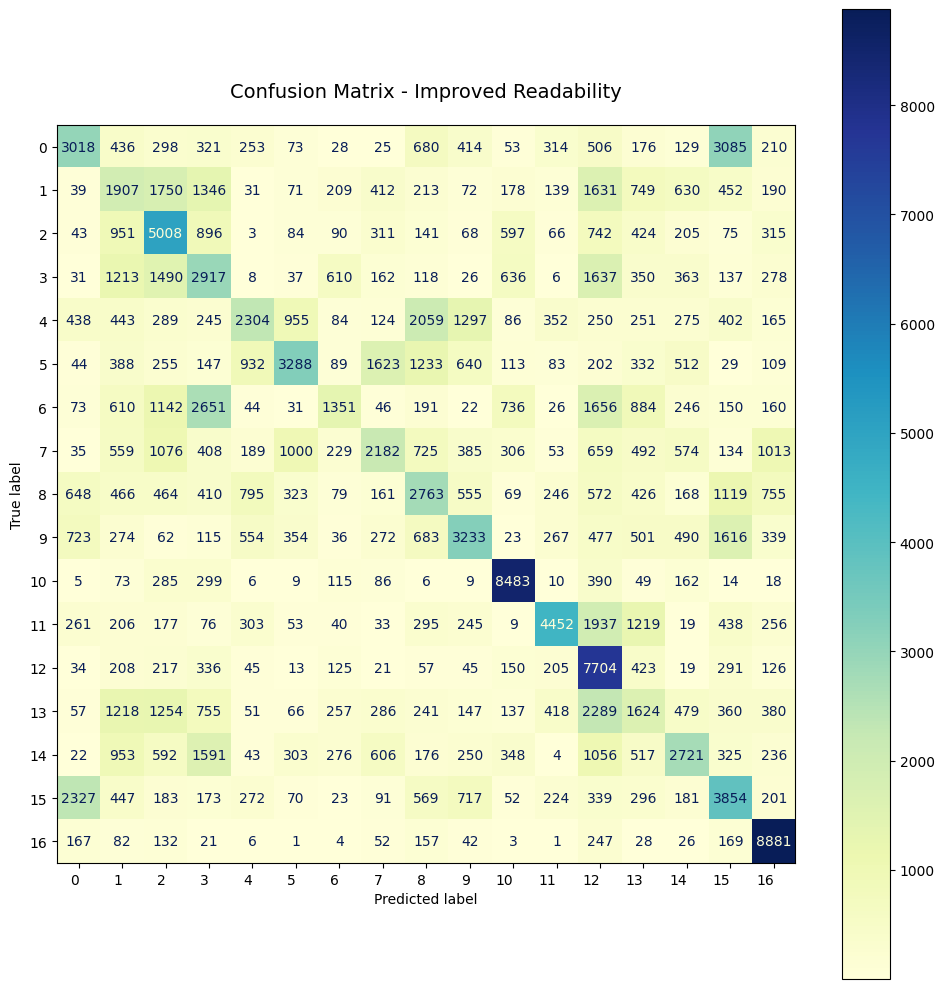

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Plot confusion matrix with better readability
fig, ax = plt.subplots(figsize=(10, 10))  # Increased figure size

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(17))
disp.plot(cmap='YlGnBu', ax=ax, values_format='d')

# Adjust font sizes for better readability
plt.xticks(rotation=0, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.title("Confusion Matrix - Improved Readability", fontsize=14, pad=20)
plt.tight_layout()
plt.show()